In [9]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance


import optuna
import logging
import warnings



/home/nikita/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
df_train=pd.read_csv('contest_train.csv')
df_test=pd.read_csv('contest_test.csv')
print(df_train.shape)
print(df_test.shape)

(18390, 262)
(6131, 261)


In [11]:
#Lets rename columns
df_train = df_train.rename(columns={'Unnamed: 0': 'id'})

In [12]:
def preprocessing(df):
    '''
    preprocessing data
    we will lower column names and delete other 
    than symbolic and numeric letters 
    '''
        #приведем колонки к нижнему регистру
    df.columns = map(str.lower, df.columns)
    #Удалим лишние симвоы
    df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

    return df



    
def clean_from_nans_and_duplicates(df,threshold = 0.45):
    '''
    cleaning data from columns with nans()
    threshold 0.45 was taken knowing that we cannot do anything with features
    with more than 0.45 nans when we don't know what the column is about
    
    '''
    
 

    print(f'Number of columns with count of Nans more than {threshold} samples' ,len(df.isnull().mean().sort_values().loc[lambda x:x>threshold]))
    df=df.drop(columns=df.isnull().mean().sort_values().loc[lambda x:x>threshold].index)
    print(f'Number of columns with count of Nans more than {threshold} samples after deleting' ,len(df.isnull().mean().sort_values().loc[lambda x:x>threshold]))
    
    print('Number of duplicated samples within dataset:', len(df.loc[lambda x:x.duplicated()]))
    
    df=df.drop_duplicates()
    print('Number of duplicated samples within dataset after dropping:', len(df.loc[lambda x:x.duplicated()]))
    
    return df

def clean_from_constans(df):
    '''
    cleaning data from features that are all the same. But there should not 
    be NaNs inside. LGBM CLassifier probably would find some logic in it
    '''
    # Get the number of unique values for each feature
    unique_counts = df[df.isnull().mean().sort_values().loc[lambda x:x==0].index].nunique()

    # Get the names of the constant features
    constant_feature_names = unique_counts[unique_counts == 1].index

    # Print the names of the constant features
    print("Constant features:", constant_feature_names)
    print('Shape of dataframe before deleting cosntant features:', df.shape)

    # Remove the constant features from the training data
    df = df.drop(columns=constant_feature_names)
    
    print('Shape of dataframe after deleting cosntant features:', df.shape)
    
    return df


def clean_from_correlation(df,threshold=0.95):
    '''
    Function cleans data from highly correlated features
    '''
    
    print(f'Shape of dataframe before deleting features with more than {threshold} correlation:',df.shape)
    # Create correlation matrix
    corr_matrix = df.drop(columns=['target','id']).corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop features 
    df=df.drop(to_drop, axis=1)
    
    print(f'Shape of dataframe after deleting features with more than {threshold} correlation:',df.shape)
        
    return df

In [13]:
df_train = preprocessing(df_train)
df_train=clean_from_nans_and_duplicates(df_train)
df_train=clean_from_correlation(df_train)
df_train=clean_from_constans(df_train)


Number of columns with count of Nans more than 0.45 samples 7
Number of columns with count of Nans more than 0.45 samples after deleting 0
Number of duplicated samples within dataset: 0
Number of duplicated samples within dataset after dropping: 0
Shape of dataframe before deleting features with more than 0.95 correlation: (18390, 255)
Shape of dataframe after deleting features with more than 0.95 correlation: (18390, 230)
Constant features: Index(['feature_144', 'feature_249', 'feature_256', 'feature_3'], dtype='object')
Shape of dataframe before deleting cosntant features: (18390, 230)
Shape of dataframe after deleting cosntant features: (18390, 226)


<AxesSubplot: xlabel='feature_80', ylabel='Count'>

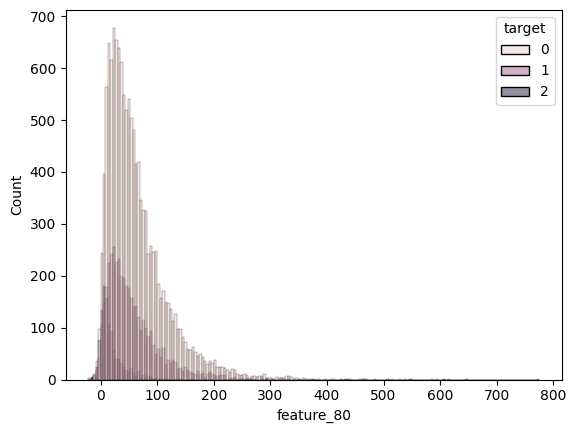

In [18]:
sns.histplot(data=df_train,x='feature_80',hue='target')

In [21]:
columns=['feature_80','feature_121','feature_238','feature_227','feature_122','feature_175','feature_203','feature_81','feature_182','feature_239','feature_71','feature_112','target']

In [24]:
df_train[['feature_80','feature_121','feature_238','target']]

,feature_80,feature_121,feature_238,target
0,38.731676,19.0,0.0,0
1,52.887748,38.0,146.0,0
2,26.110984,8.0,4.0,2
3,57.927428,22.0,56.0,0
4,3.215111,10.0,20.0,1
...,...,...,...,...
18385,28.247926,32.0,87.0,0
18386,72.425317,18.0,7.0,0
18387,93.872792,39.0,45.0,1
18388,8.077952,6.0,0.0,1


## SNS PAIRPLOT FOR MOST IMPORTANT FEATURES WITH HUE WITH TARGET

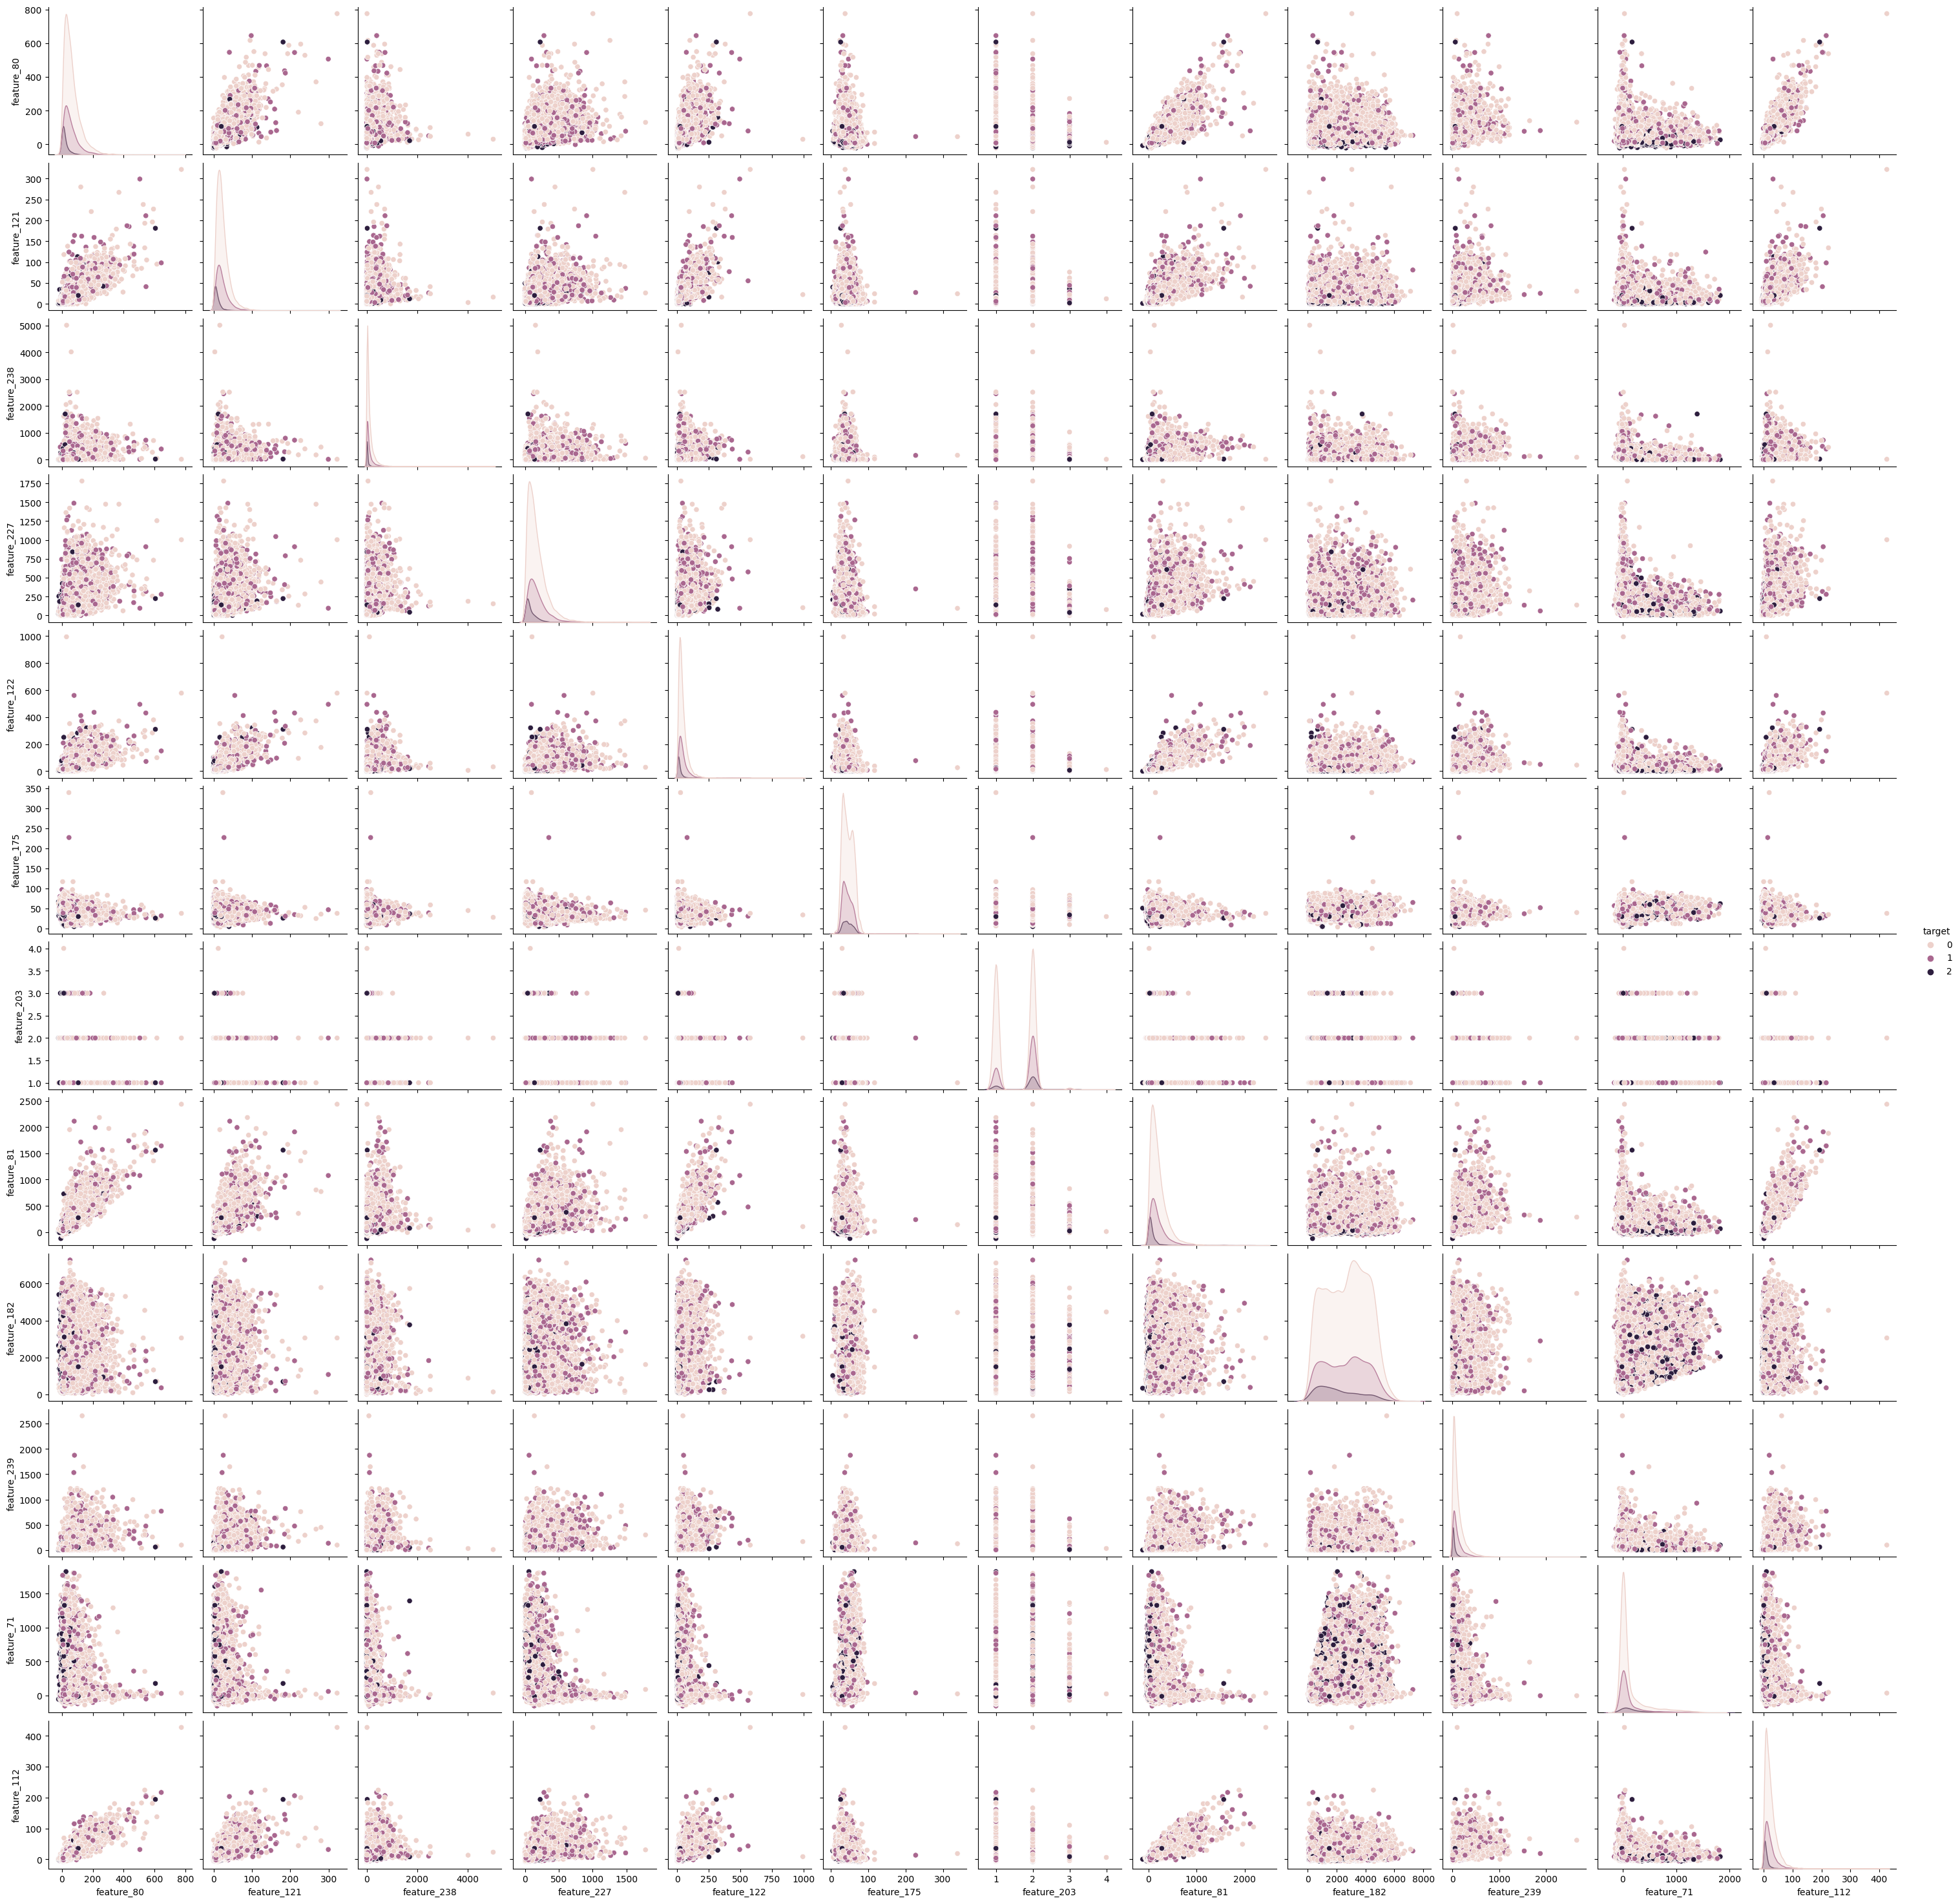

In [28]:
sns.pairplot(data=df_train[['feature_80','feature_121','feature_238','feature_227','feature_122','feature_175','feature_203','feature_81','feature_182','feature_239','feature_71','feature_112','target']],hue='target')